In [22]:
import gc
import os
import time
import collections

import umap
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import MASI as masi

from scipy import io
from scipy.sparse import csr_matrix

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

#from sccoda.util import comp_ana as mod
#from sccoda.util import cell_composition_data as dat
#rom sccoda.util import data_visualization as viz
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [6]:
##human kidney atlas
h4c_file = "D:/GEO/SMILE/H5AD/Mature_Full_v3.h5ad"
source = sc.read_h5ad(h4c_file)
sc.pp.filter_cells(source, min_genes=500)
source.obs['Source']="reference"
#source = source[source.obs['compartment']!='PT']
source.obs['cell_type']=source.obs['broad_celltype']
#source.obs['cell_type']=source.obs['compartment']
print(source.X.shape)

(25128, 33694)


In [8]:
data_file = "D:/GEO/MASI/Kidney/human_kidney_sn_control.csv"
data = pd.read_csv(data_file,header=0,index_col=0)
data = data.groupby('genes').sum()
data = data.T

target= anndata.AnnData(X=data)
#y = pd.read_csv("human_kidney_sn_control_celltype.csv",header=None,index_col=False,sep='\t')
#target.obs['cell_type']=y[0].values
sc.pp.normalize_total(target, target_sum=1e4)
sc.pp.log1p(target)
target.obs['Source']="DKD_control"
print(target.X.shape)

(16588, 22389)


In [9]:
data_file = "D:/GEO/MASI/Kidney/human_kidney_sn_diabetes.csv"
data = pd.read_csv(data_file,header=0,index_col=0)
data = data.groupby('genes').sum()
data = data.T

target2= anndata.AnnData(X=data)
sc.pp.normalize_total(target2, target_sum=1e4)
sc.pp.log1p(target2)
target2.obs['Source']="DKD"
print(target2.X.shape)

(12128, 22046)


In [10]:
data_file = "D:/GEO/MASI/Kidney/exprMatrixSleBroad.tsv"
data = pd.read_csv(data_file,header=0,index_col=0,sep='\t')
data = data.T

y = pd.read_csv("D:/GEO/MASI/Kidney/meta",header=0,index_col=0,sep='\t')
tf=[]
for i in y.index.tolist(): 
    if i in data.index.tolist():
        tf.append(True)
    else:
        tf.append(False)
y = y[np.array(tf)]

target3= anndata.AnnData(X=data,obs=y)
target3.obs['Source']="LN"
print(target3.X.shape)

(2838, 22447)


In [11]:
data_file = "D:/GEO/MASI/Kidney/allograft_exprMatrix.tsv"
data = pd.read_csv(data_file,header=0,index_col=0,sep='\t')
data = data.T

y = pd.read_csv("D:/GEO/MASI/Kidney/allograft_meta.tsv",header=0,index_col=0,sep='\t')

genes = data.columns.tolist()
newgenes = [i.split("|")[0] for i in genes]
data.columns = newgenes

target4= anndata.AnnData(X=data, obs=y)
sc.pp.normalize_total(target4, target_sum=1e4)
sc.pp.log1p(target4)
target4.obs['Source']="Allograft"
print(target4.X.shape)

(4487, 20477)


In [12]:
genes = pd.read_table("D:/GEO/MASI/Kidney/CD10negative/kidneyMap_UMI_counts_rowData.txt",header=0,index_col=False,sep=',')
metadata = pd.read_csv("D:/GEO/MASI/Kidney/CD10negative/kidneyMap_UMI_counts_colData.txt",header=0,index_col=False)
data = "D:/GEO/MASI/Kidney/CD10negative/kidneyMap_UMI_counts.mtx"
data = io.mmread(data)
data = csr_matrix(data)
data = data.T
target5 = anndata.AnnData(X=data)
sc.pp.normalize_total(target5, target_sum=1e4)
sc.pp.log1p(target5)
target5.var.index = genes['Gene.Symbol'].values
target5.obs=metadata
target5=target5[:,~target5.var.index.duplicated()]
target5.obs['Source']="CKD"
print(target5.X.shape)

(51849, 23330)


In [13]:
var_names = source.var_names.intersection(target.var_names)
var_names = target2.var_names.intersection(var_names)
var_names = target3.var_names.intersection(var_names)
var_names = target4.var_names.intersection(var_names)
var_names = target5.var_names.intersection(var_names)
source = source[:,var_names]
target = target[:,var_names]
target2 = target2[:,var_names]
target3 = target3[:,var_names]
target4 = target4[:,var_names]
target5 = target5[:,var_names]

In [18]:
adata = source.concatenate(target,target2,target3,target4,target5)
# adata = sc.read_h5ad("E:h5ad/Kidney_combined.h5ad")

In [19]:
markers = pd.read_csv("ReferenceMarkers/human_kidney_stewart_markers.csv",header=0,index_col=False)
cell_markers={}
for m in markers.columns:
    cell_markers[m]=markers[m].values.tolist()

In [20]:
sc.set_figure_params(scanpy=True, dpi=300, dpi_save=300)

In [23]:
##run MASI
marker_list = []
for k, v in cell_markers.items():
    marker_list += v
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)
ad = adata[:,marker_list]

##step 1 expression to cell type score
start_time = time.time()
scores, labels = masi.gene2cell(ad=ad,cell_markers=cell_markers,
                                use_weight=True,if_tfidf=True,if_thresh=True,thresh=0.9)

##step 2 parallel annotation
#cluster every 50000 cells in each batch
annotation = masi.parallel(scores=scores,labels=labels,batch_size=50000)
annotation = np.array(annotation)
print("--- %s mins ---" % int((time.time() - start_time)/60))

adata.obs['Annotation']=annotation

(113018, 27)
--- 3 mins ---


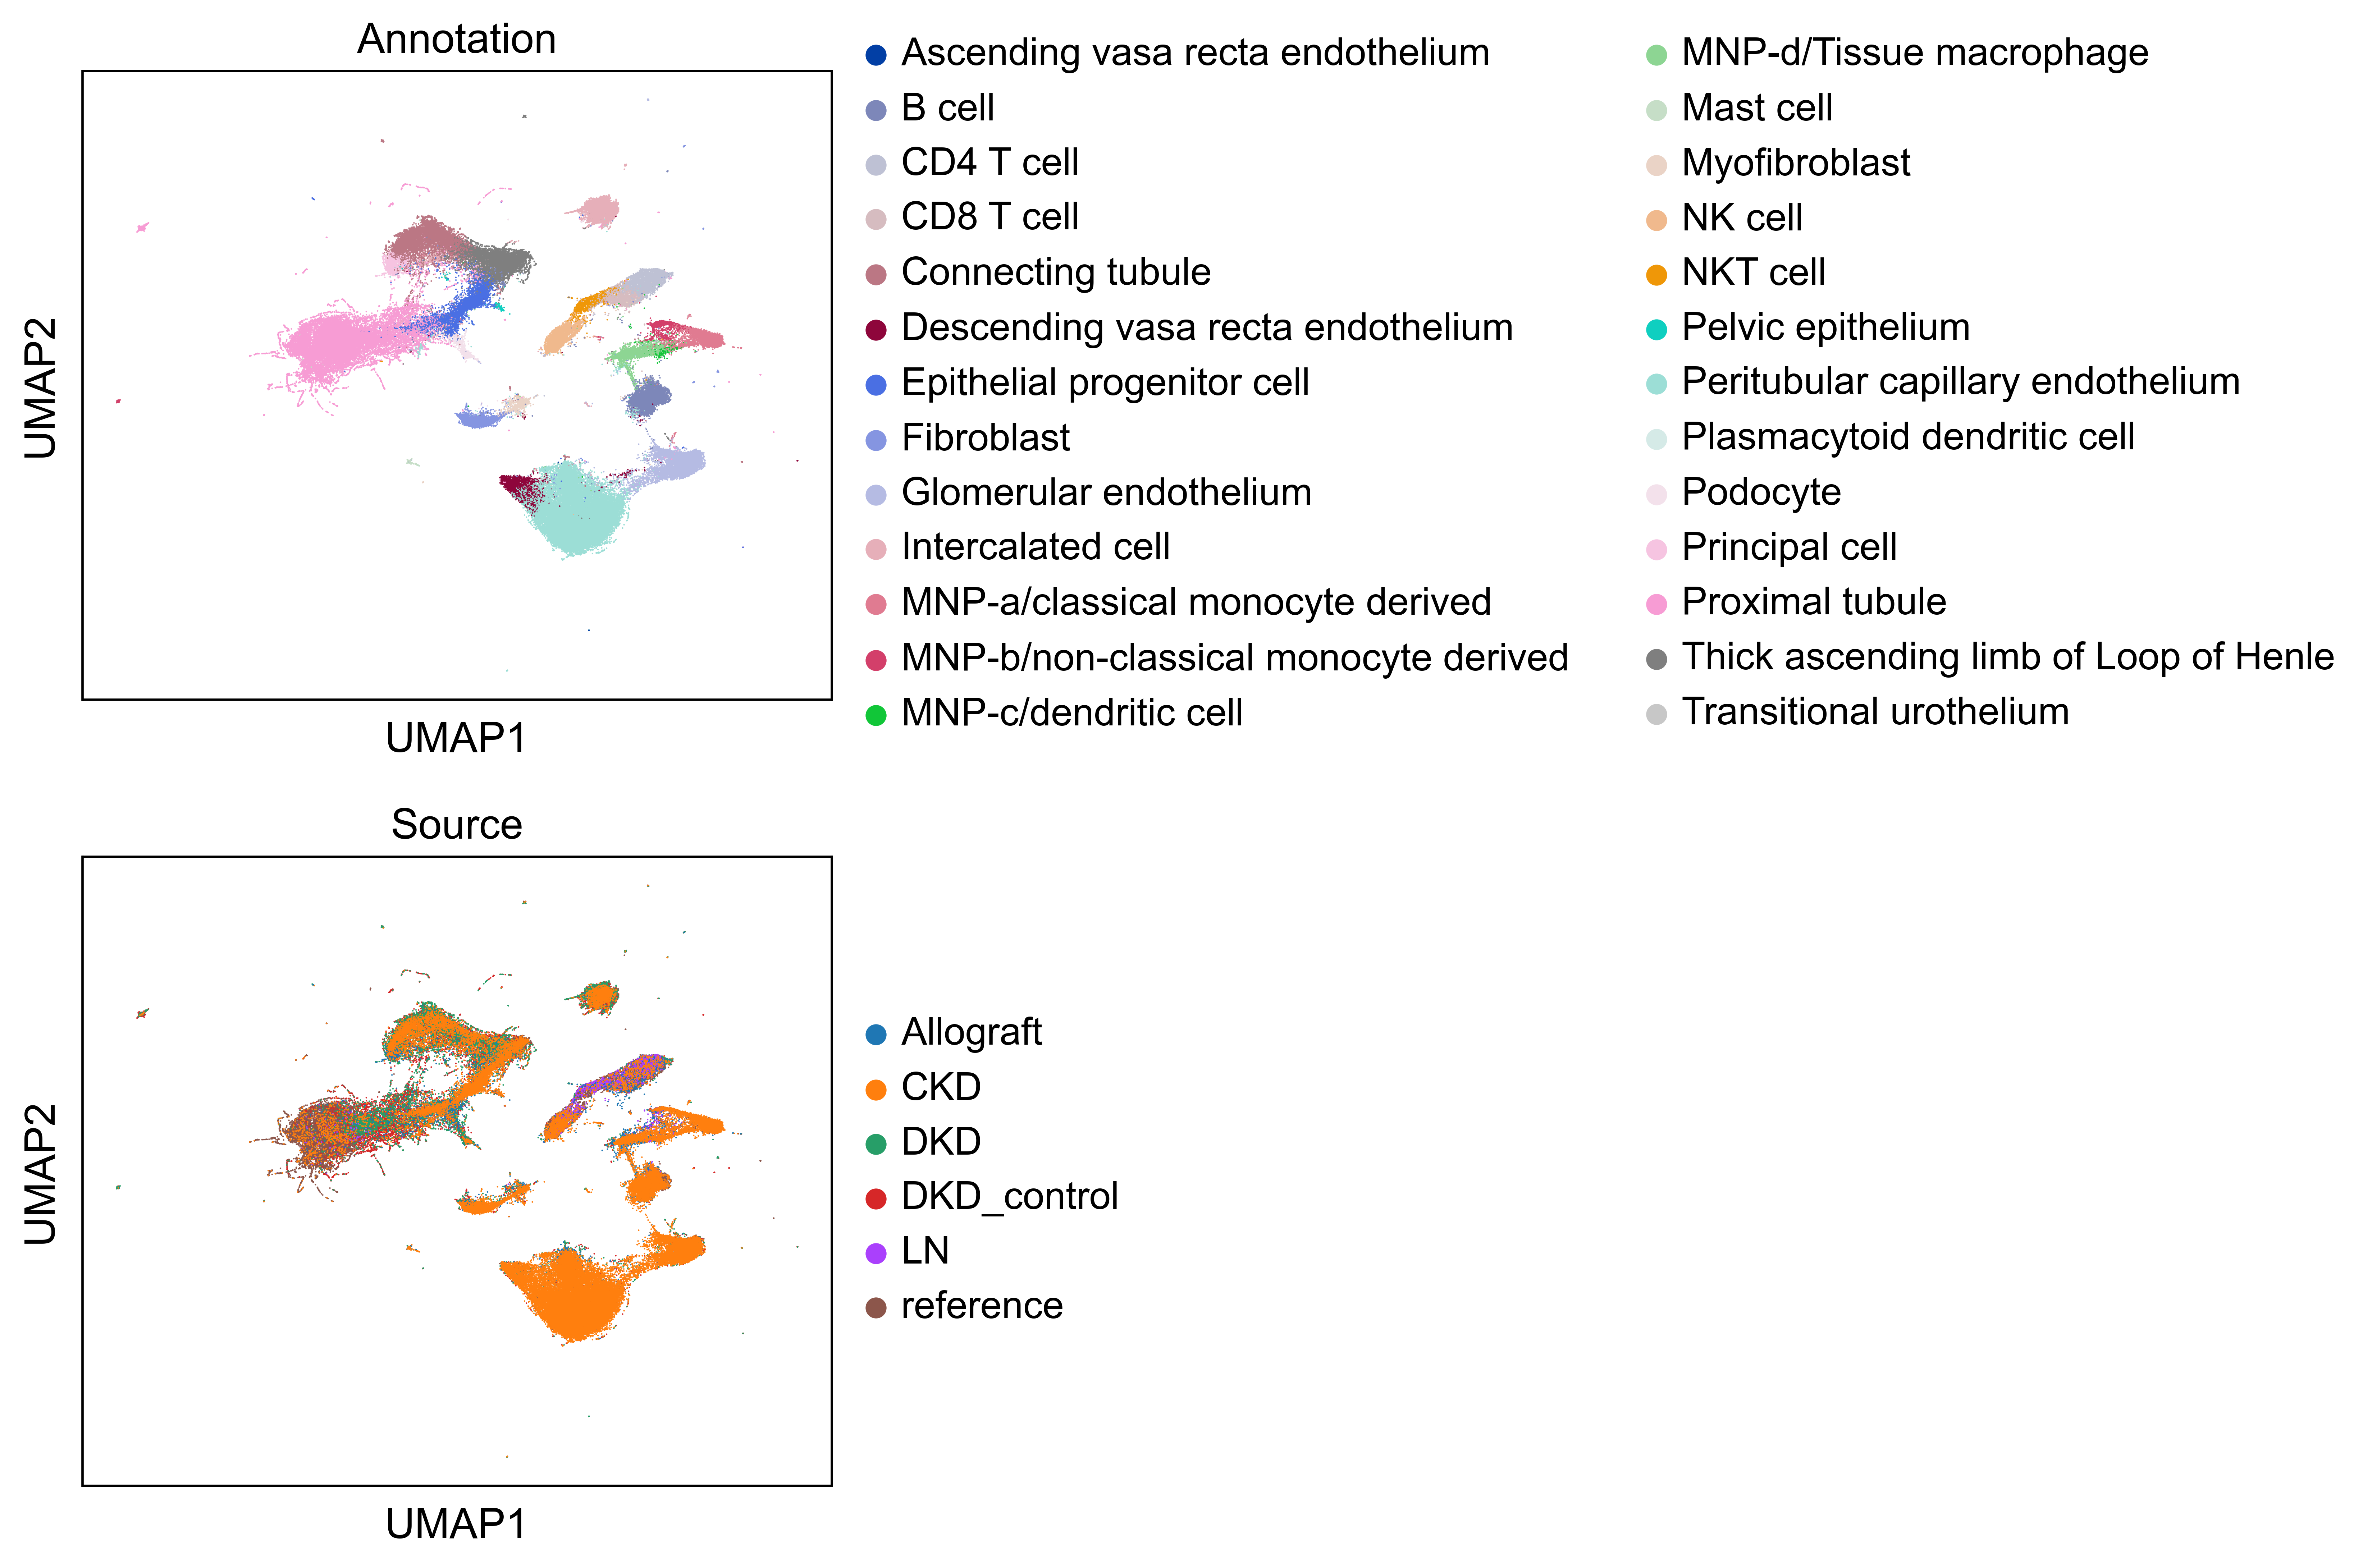

In [24]:
##visualization
down_samp = pd.DataFrame(scores.values)
#down_samp = down_samp.sample(frac=0.5)
umaps = umap.UMAP(n_neighbors=15, min_dist=0.15, n_components=2,
                  metric="cosine").fit(down_samp.values)
embedding = umaps.transform(scores.values)

embedding = pd.DataFrame(embedding)
embedding.columns=['UMAP1','UMAP2']
adata.obsm['X_umap'] = embedding.iloc[:,:2].values
adata.obs['Annotation']=annotation
sc.pl.umap(adata, color=["Annotation","Source"],ncols=1)
#sc.pl.umap(adata, color=["Annotation"],save='kidney.svg')

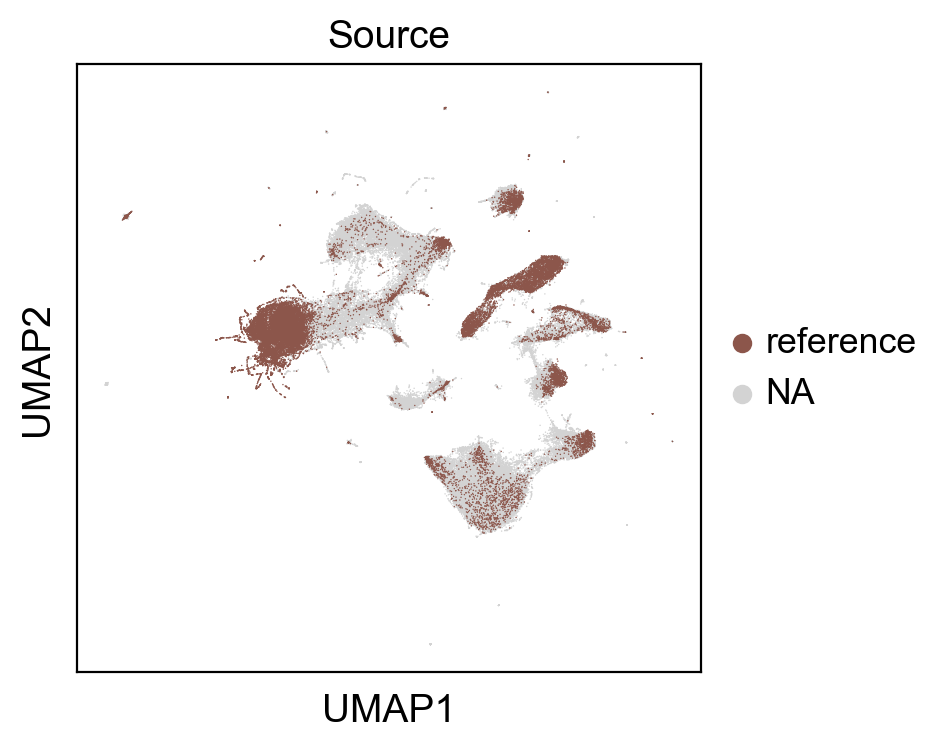

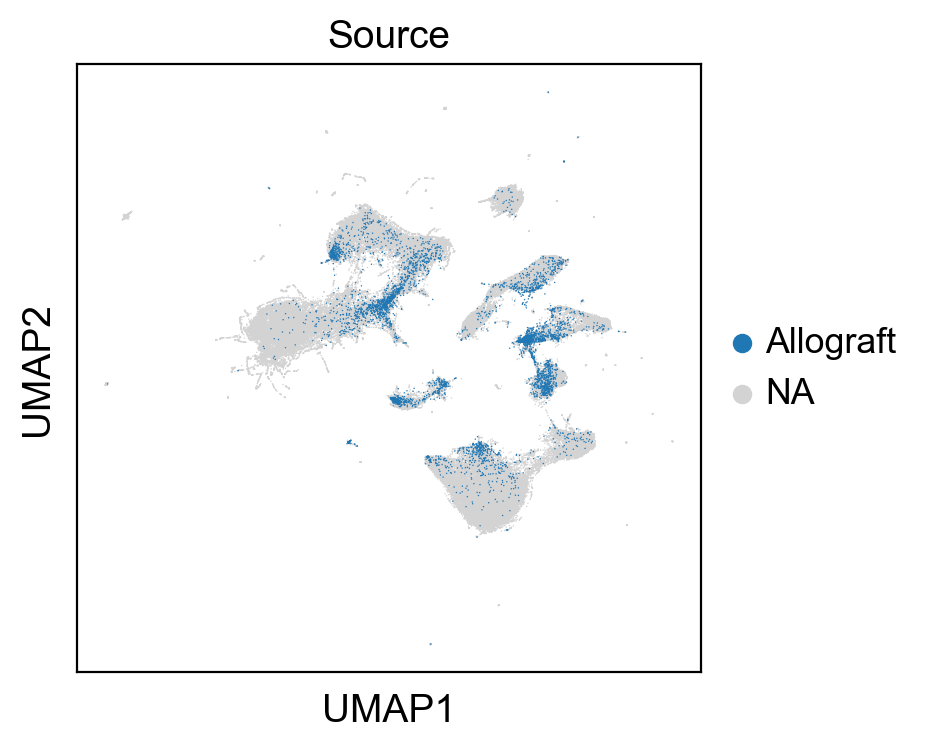

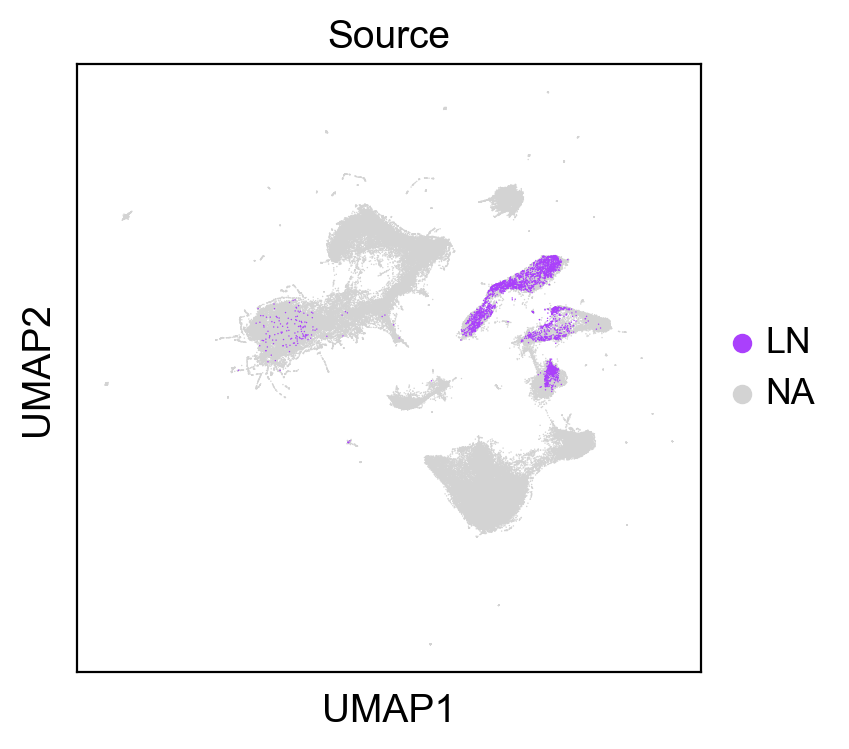

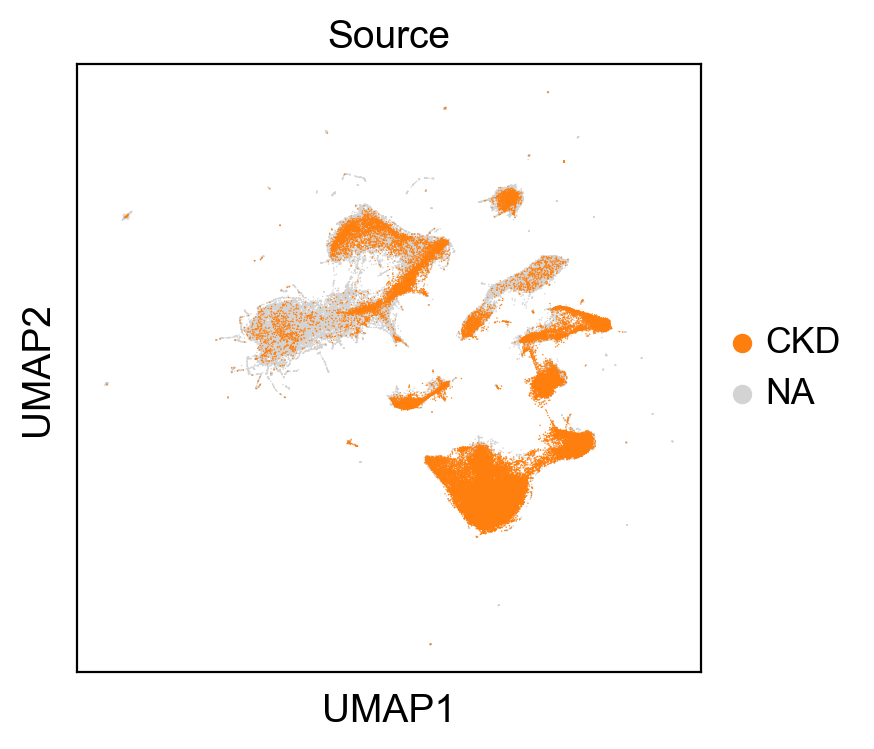

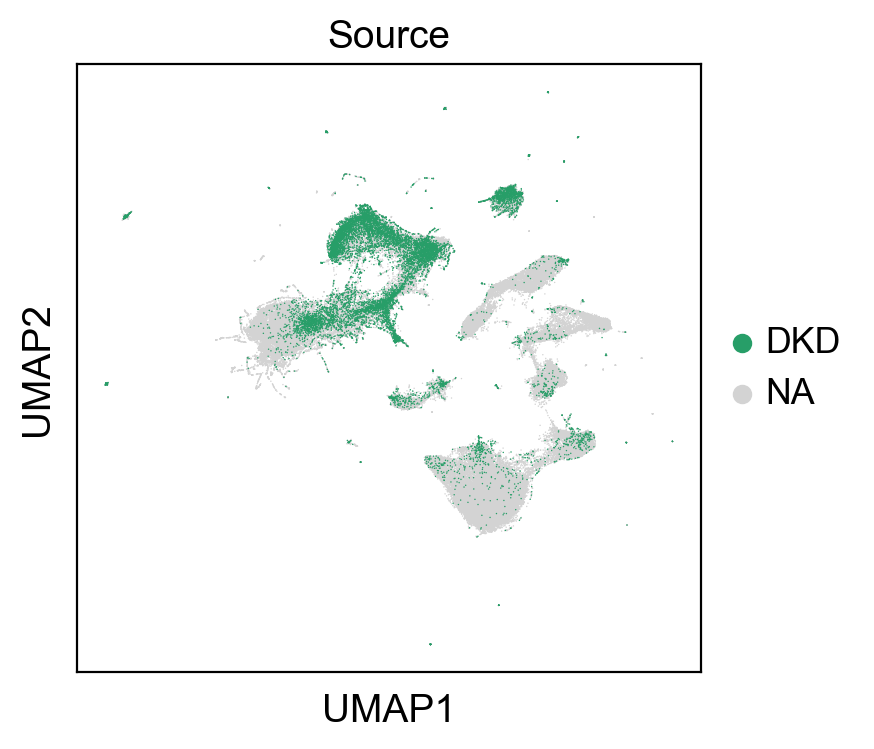

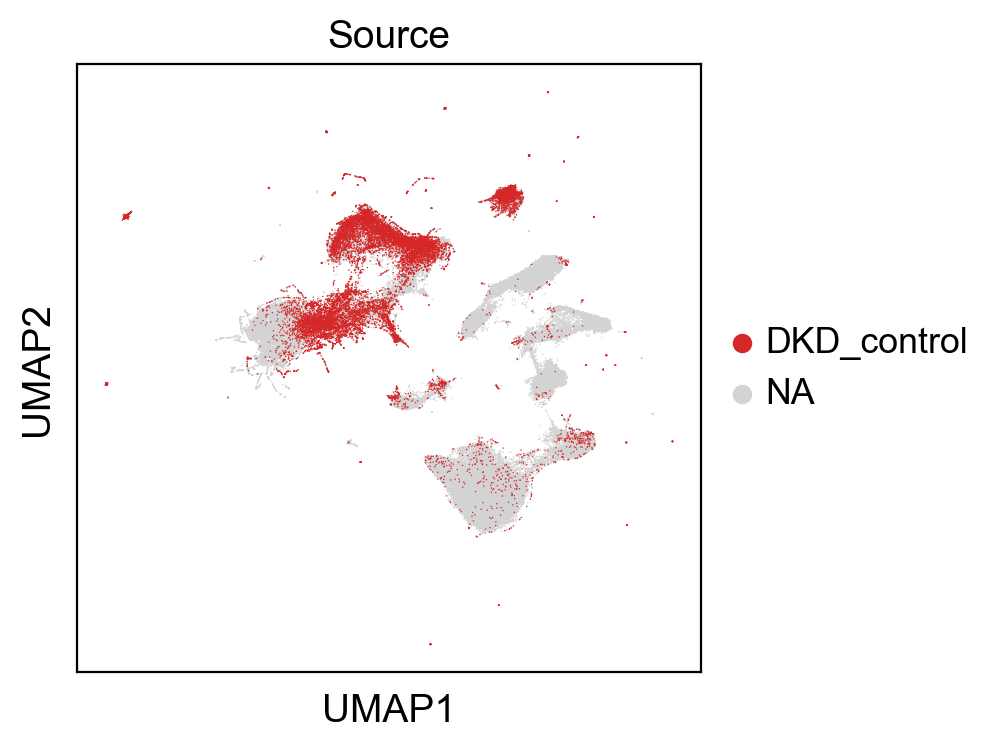

In [25]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100)
for batch in ['reference','Allograft', 'LN', 'CKD','DKD','DKD_control']:
    sc.pl.umap(adata, color='Source', groups=[batch]) #,save=batch+'.svg')

In [26]:
print(round(adjusted_rand_score(target5.obs['Annotation.Level.1'],np.array(annotation)[adata.obs['Source']=='CKD']),3))
print(round(normalized_mutual_info_score(target5.obs['Annotation.Level.1'],np.array(annotation)[adata.obs['Source']=='CKD']),3))
print('------')
print(round(adjusted_rand_score(target5.obs['Annotation.Level.2'],np.array(annotation)[adata.obs['Source']=='CKD']),3))
print(round(normalized_mutual_info_score(target5.obs['Annotation.Level.2'],np.array(annotation)[adata.obs['Source']=='CKD']),3))
print('------')
print(round(adjusted_rand_score(target5.obs['Annotation.Level.3'],np.array(annotation)[adata.obs['Source']=='CKD']),3))
print(round(normalized_mutual_info_score(target5.obs['Annotation.Level.3'],np.array(annotation)[adata.obs['Source']=='CKD']),3))

0.58
0.602
------
0.694
0.718
------
0.256
0.631


In [27]:
print(round(adjusted_rand_score(target4.obs['Cluster'],np.array(annotation)[adata.obs['Source']=='Allograft']),3))
print(round(normalized_mutual_info_score(target4.obs['Cluster'],np.array(annotation)[adata.obs['Source']=='Allograft']),3))

0.361
0.486


In [28]:
print(round(adjusted_rand_score(target3.obs['Cluster'],np.array(annotation)[adata.obs['Source']=='LN']),3))
print(round(normalized_mutual_info_score(target3.obs['Cluster'],np.array(annotation)[adata.obs['Source']=='LN']),3))

0.448
0.641


In [31]:
#import seaborn as sns
#import matplotlib.pyplot as plt
#from sccoda.util import comp_ana as mod
#from sccoda.util import cell_composition_data as dat
#from sccoda.util import data_visualization as viz

In [34]:
patients = list(set(adata.obs['Source']))
celltypes = list(set(adata.obs['Annotation']))
ad_coda_pd = np.zeros((len(patients),len(celltypes)+1))
for p in range(len(patients)):
    subad = adata[adata.obs['Source']==patients[p]]
    for i in range(len(celltypes)):
        subcell = subad[subad.obs['Annotation']==celltypes[i]]
        ad_coda_pd[p,i]=subcell.X.shape[0]
        
ad_coda_pd = pd.DataFrame(ad_coda_pd)
celltypes.append('Individuals')
ad_coda_pd.columns = celltypes
ad_coda_pd.iloc[:,-1]=patients
ad_coda_pd = ad_coda_pd[np.logical_or(ad_coda_pd['Individuals']=='DKD',ad_coda_pd['Individuals']=='DKD_control')]
ad_coda_pd.to_csv("DKD_composition.csv")
#ad_coda = dat.from_pandas(ad_coda_pd, covariate_columns=["Individuals"])

In [30]:
#sns.set(font_scale=3)
#viz.stacked_barplot(ad_coda, feature_name="Individuals", figsize=(36,24))
#plt.savefig('kidney_comp.svg',dpi=600)

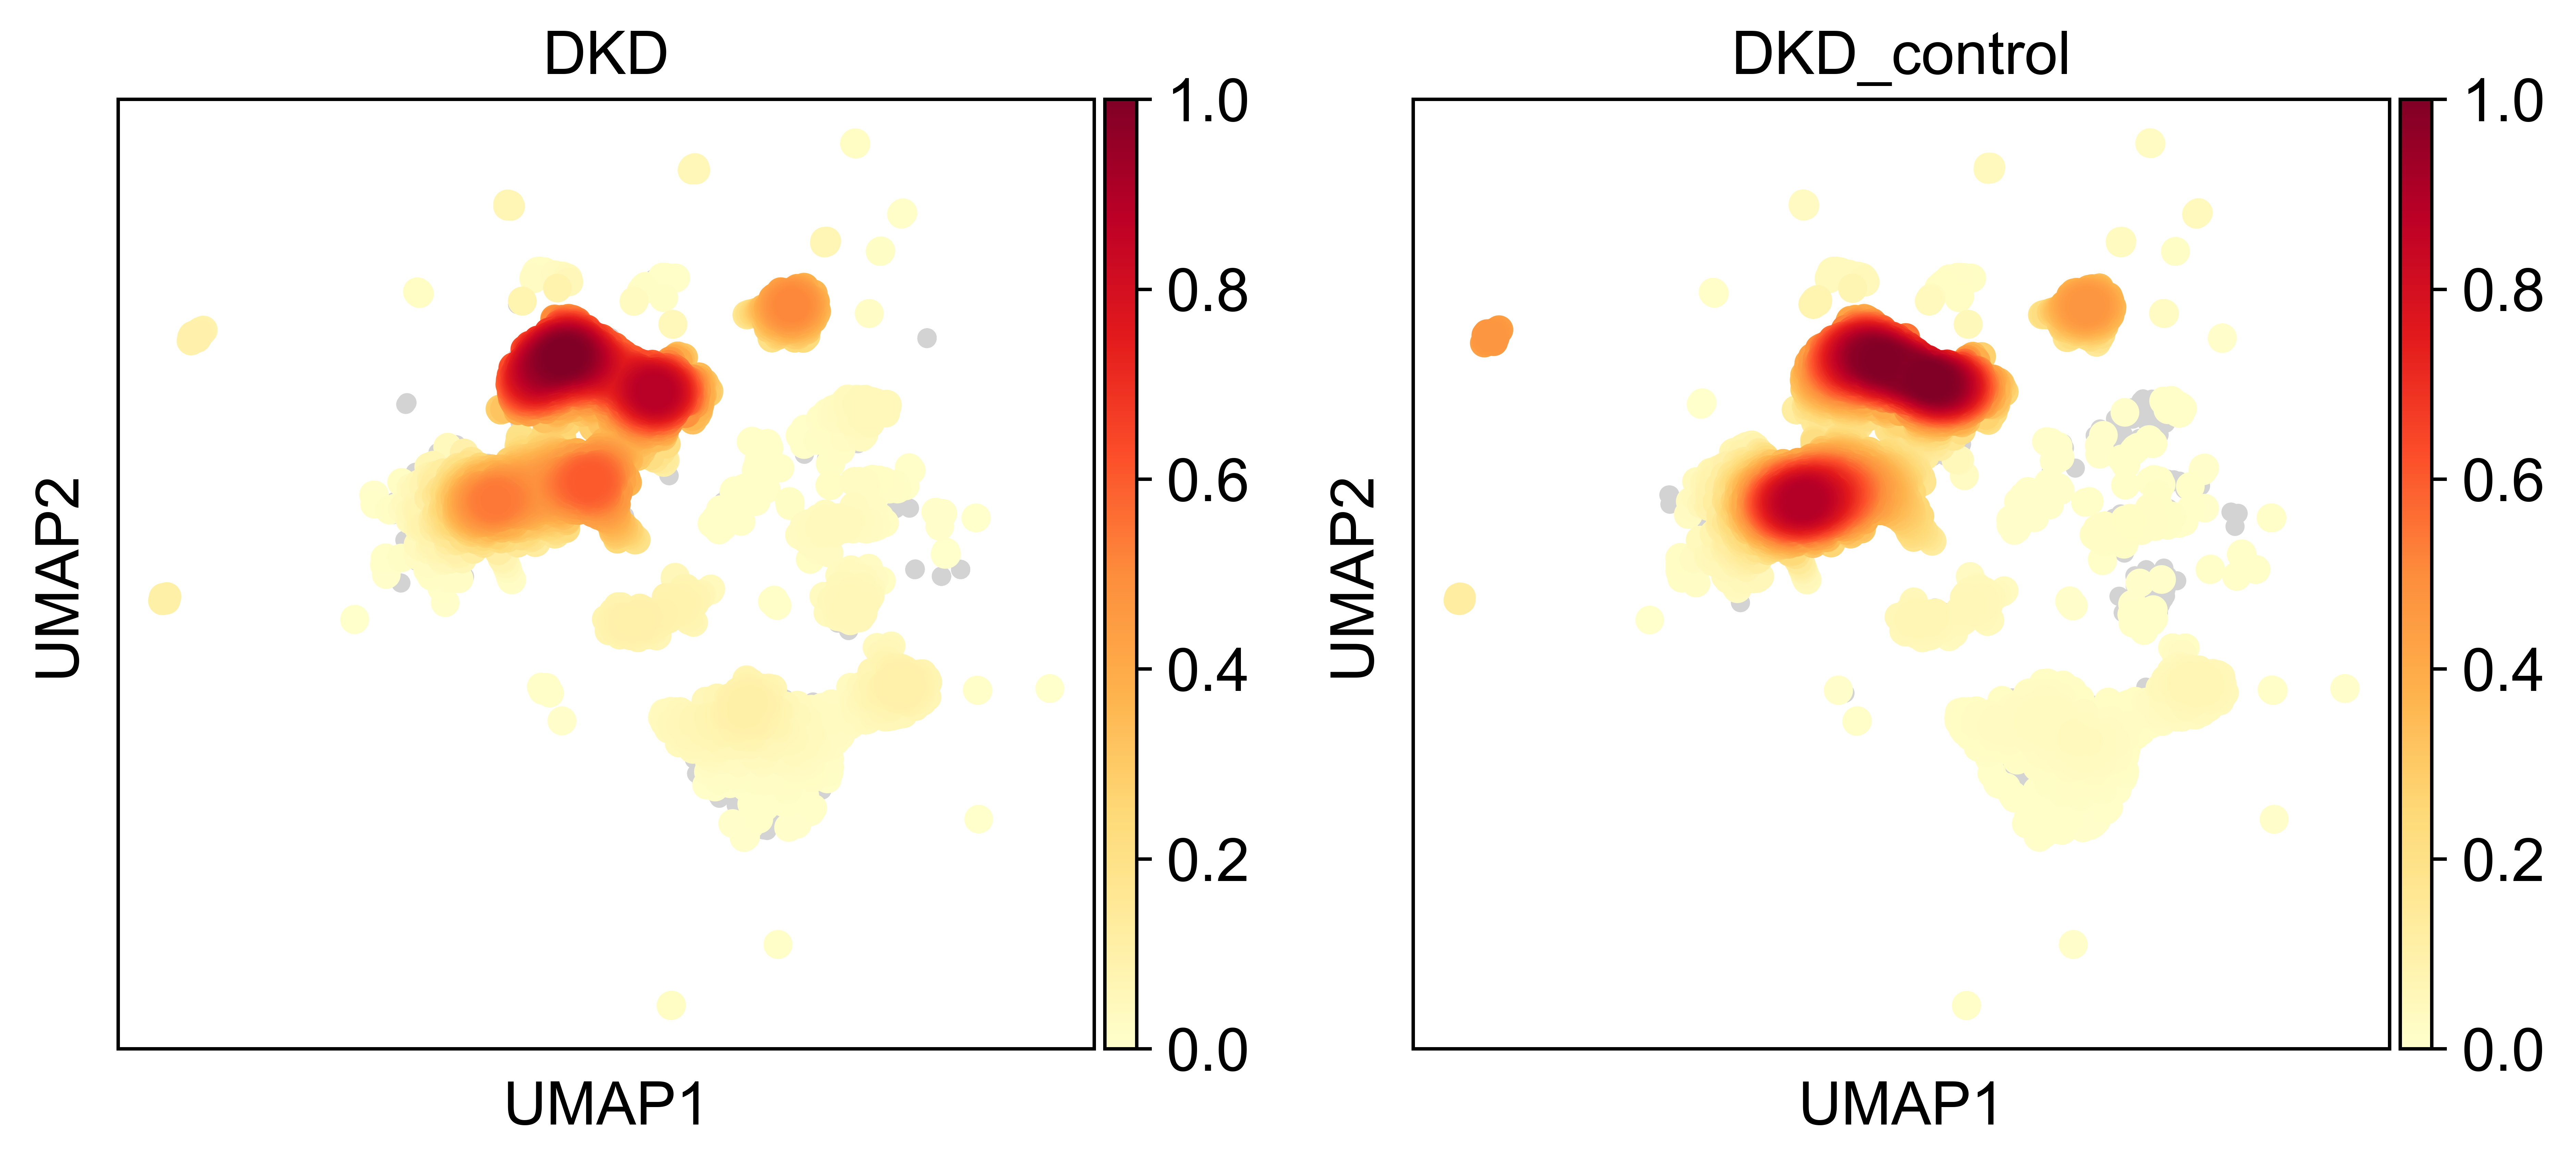

In [35]:
sc.set_figure_params(scanpy=True, dpi=450, dpi_save=450)
subad = adata[np.logical_or(adata.obs['Source'].values=='DKD',
                            adata.obs['Source'].values=='DKD_control')]

sc.tl.embedding_density(subad, groupby='Source')
sc.pl.embedding_density(subad, groupby='Source') #,save='kidney_immune.svg')

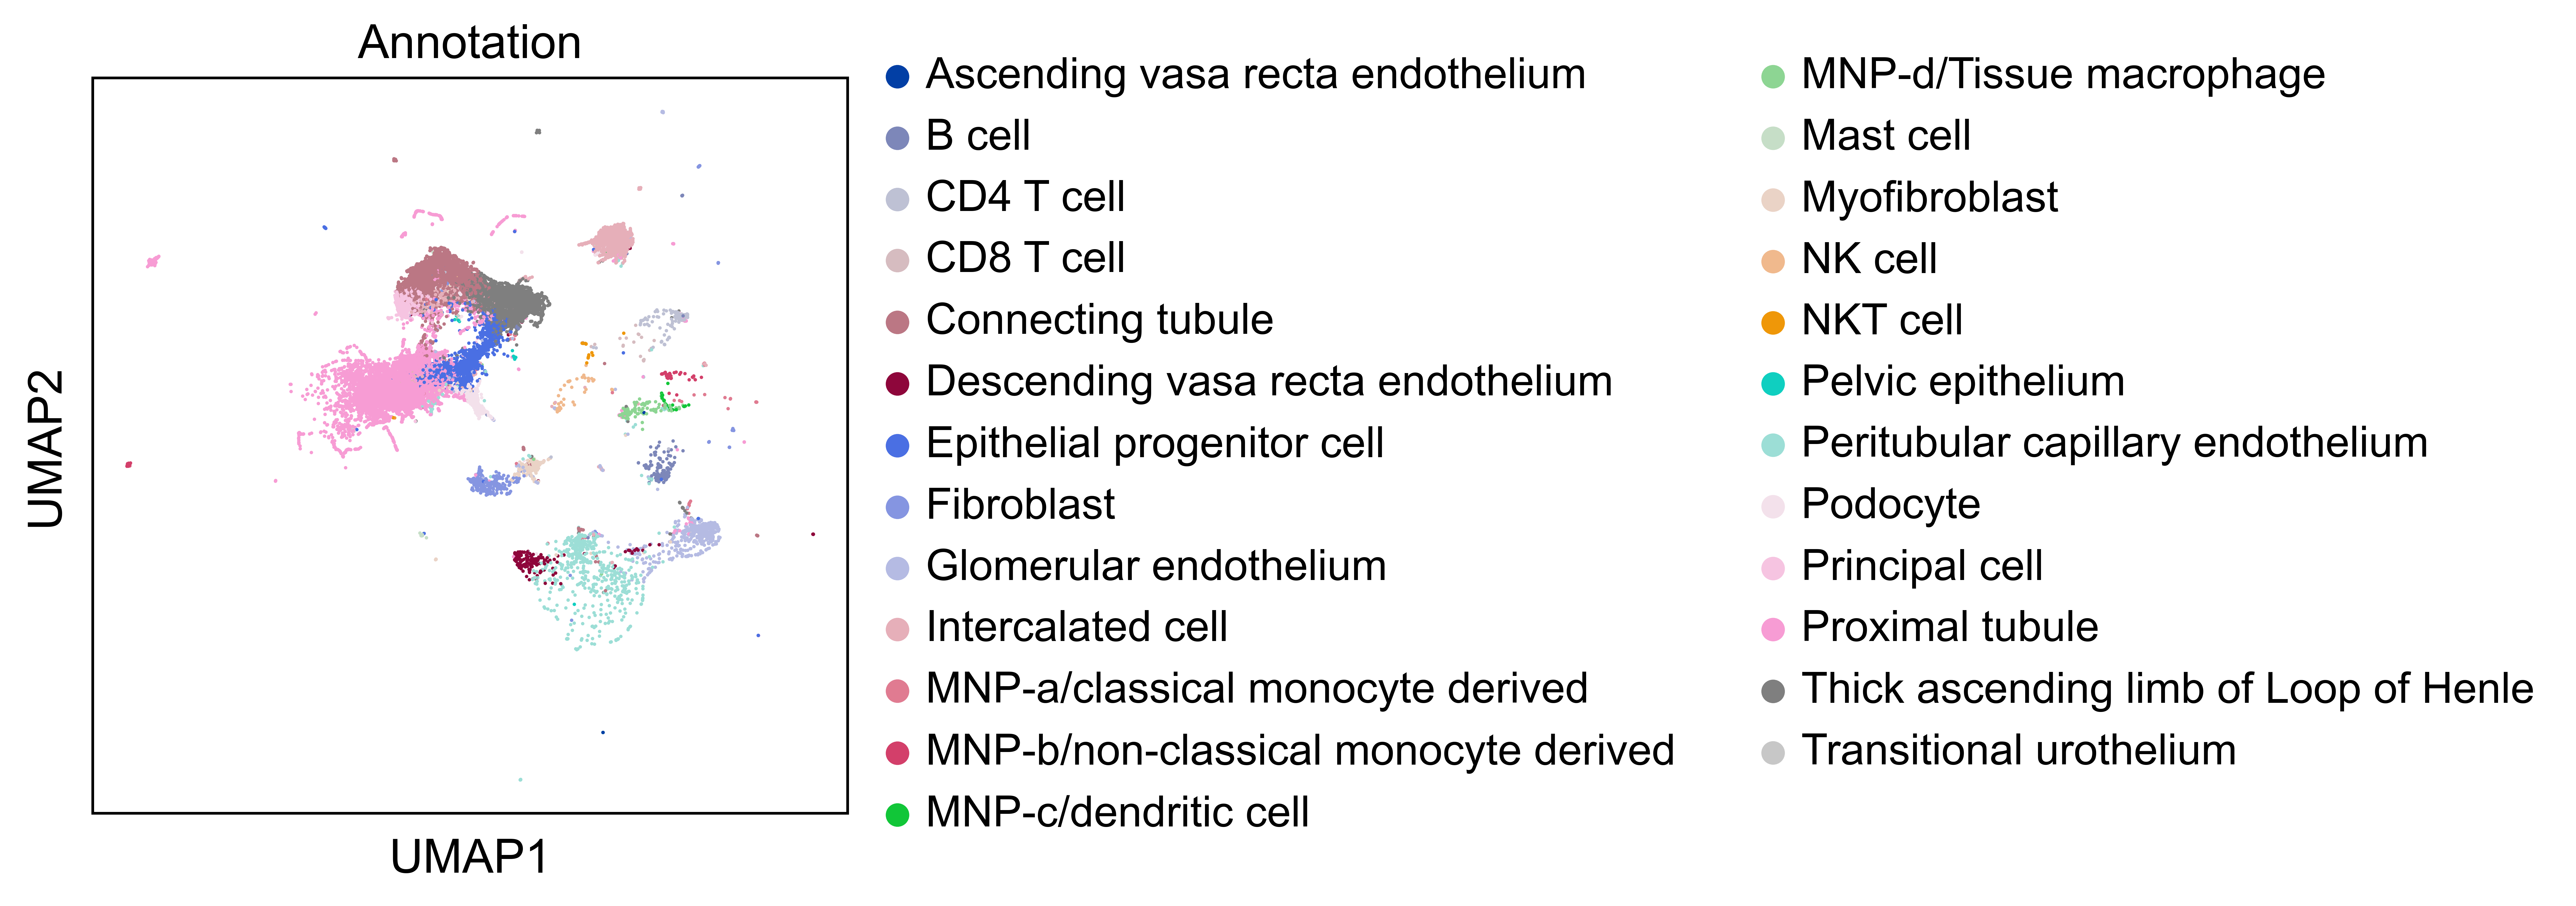

In [36]:
sc.pl.umap(subad, color=["Annotation"]) #,save='kidney_dkd.svg')

In [37]:
subtypes = subad.obs['Annotation'].values.tolist()

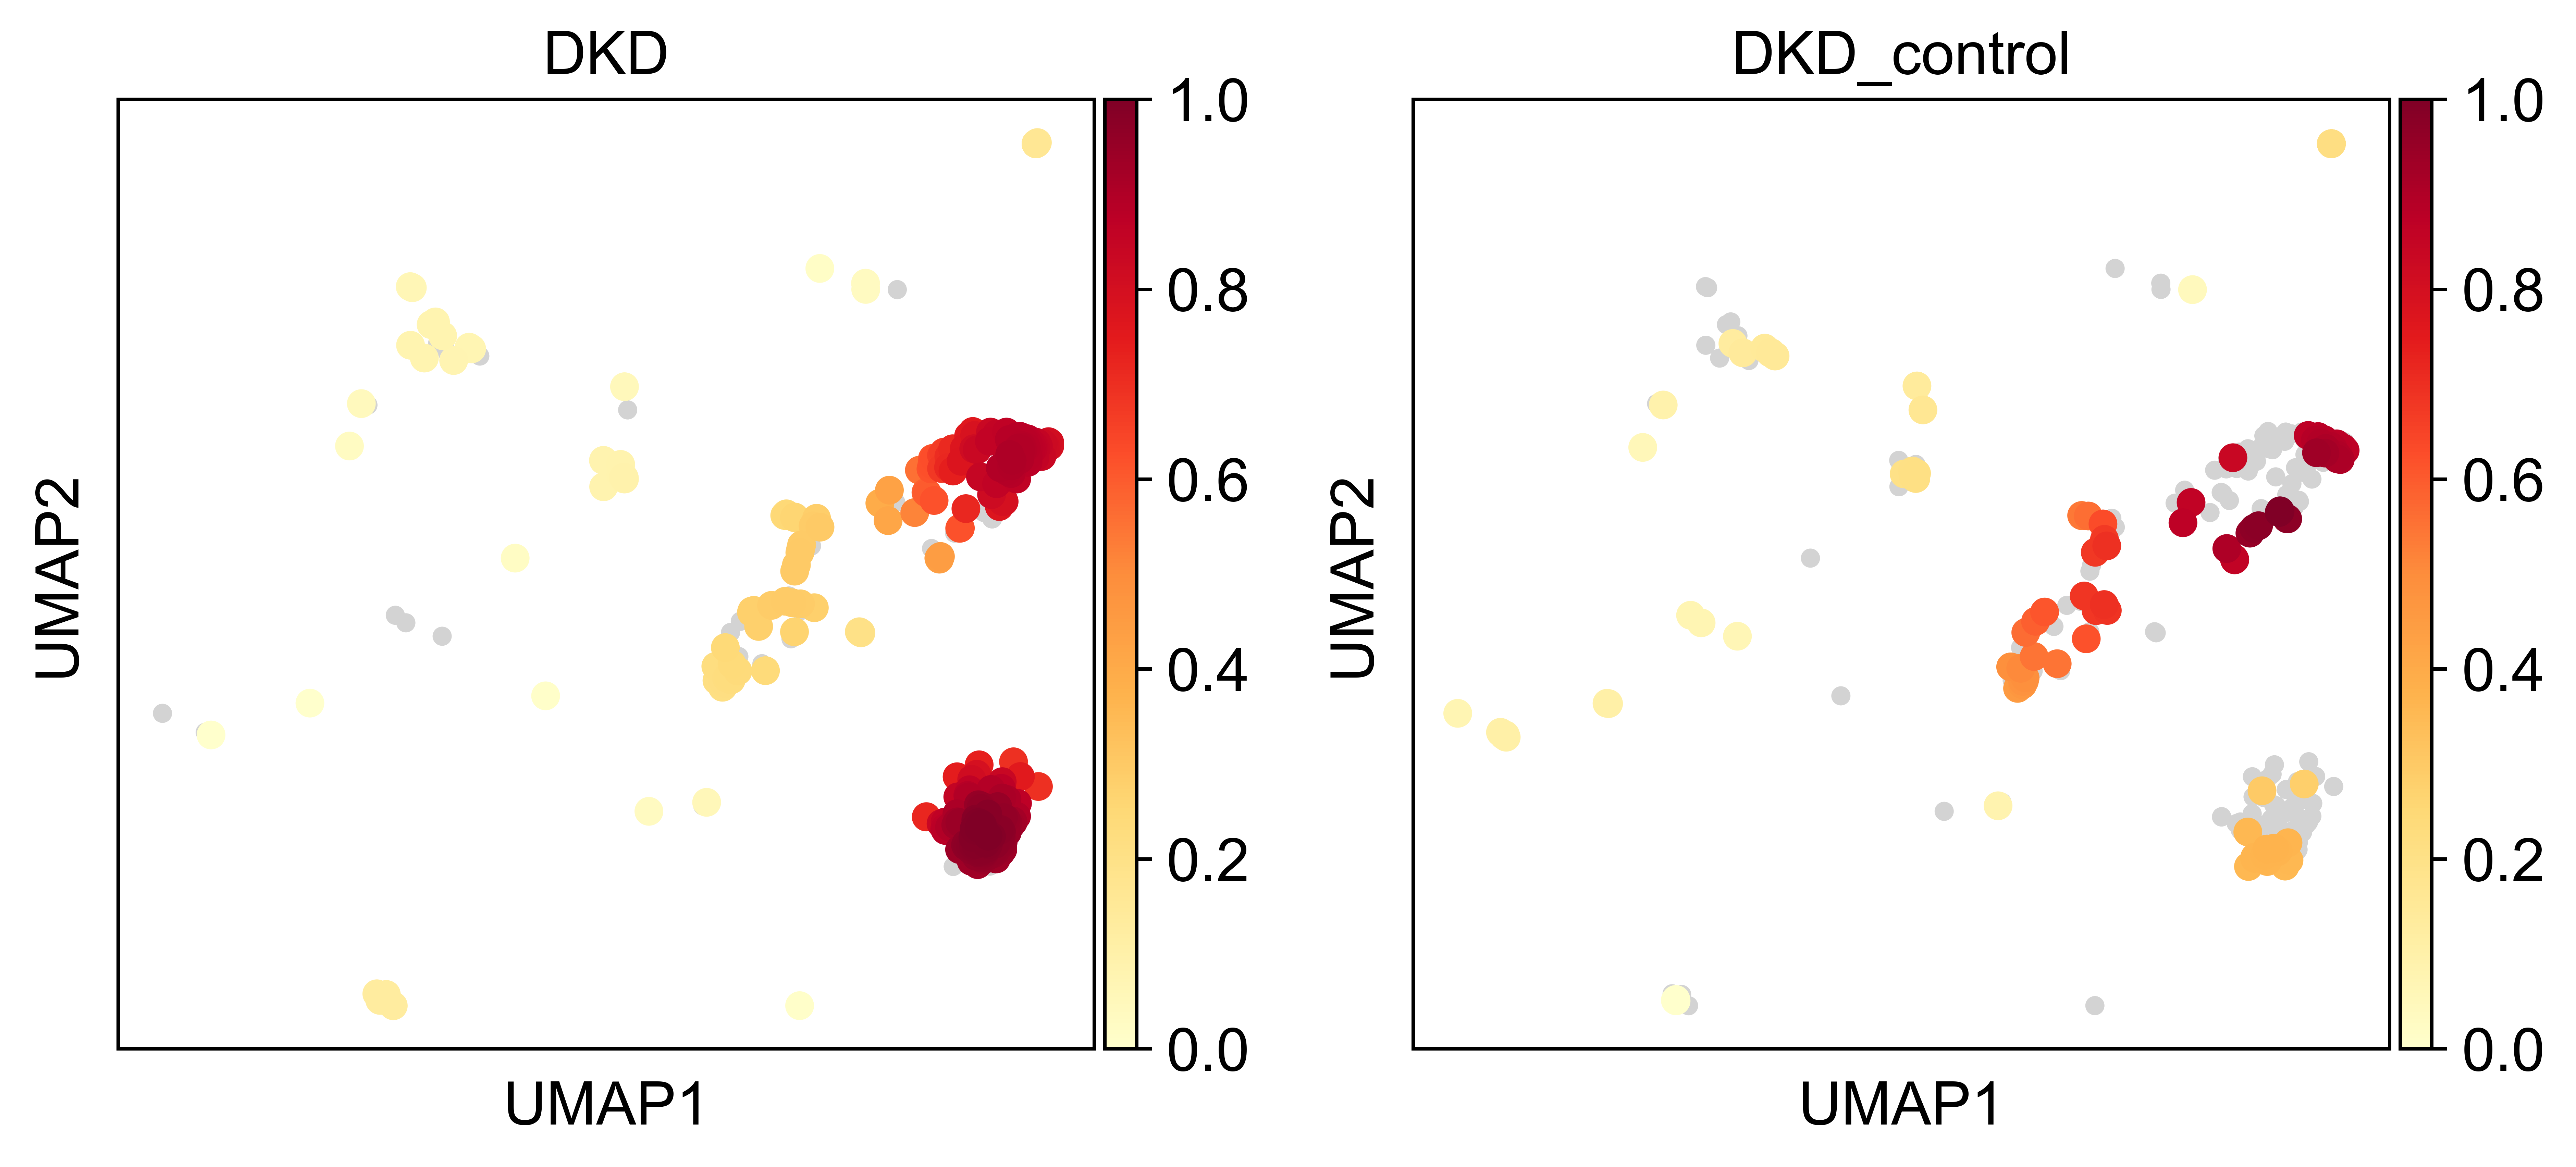

In [41]:
newsubtypes = []
for i in range(len(subtypes)):
    cell = subtypes[i]
    if cell in ["B cell","CD4 T cell",'CD8 T cell','Mast cell','NK cell','NKT cell',
                'Plasmacytoid dendritic cell']:
        newsubtypes.append('immune cells')
    else:
        newsubtypes.append('non-immune cells')
subad.obs['major']=newsubtypes
subad2 = subad[subad.obs['major'].values=='immune cells']
sc.tl.embedding_density(subad2, groupby='Source')
sc.pl.embedding_density(subad2, groupby='Source')#,save='kidney_immune_density.svg')
#"MNP-a/classical monocyte derived","MNP-b/non-classical monocyte derived",#"MNP-c/dendritic cell",'MNP-d/Tissue macrophage',

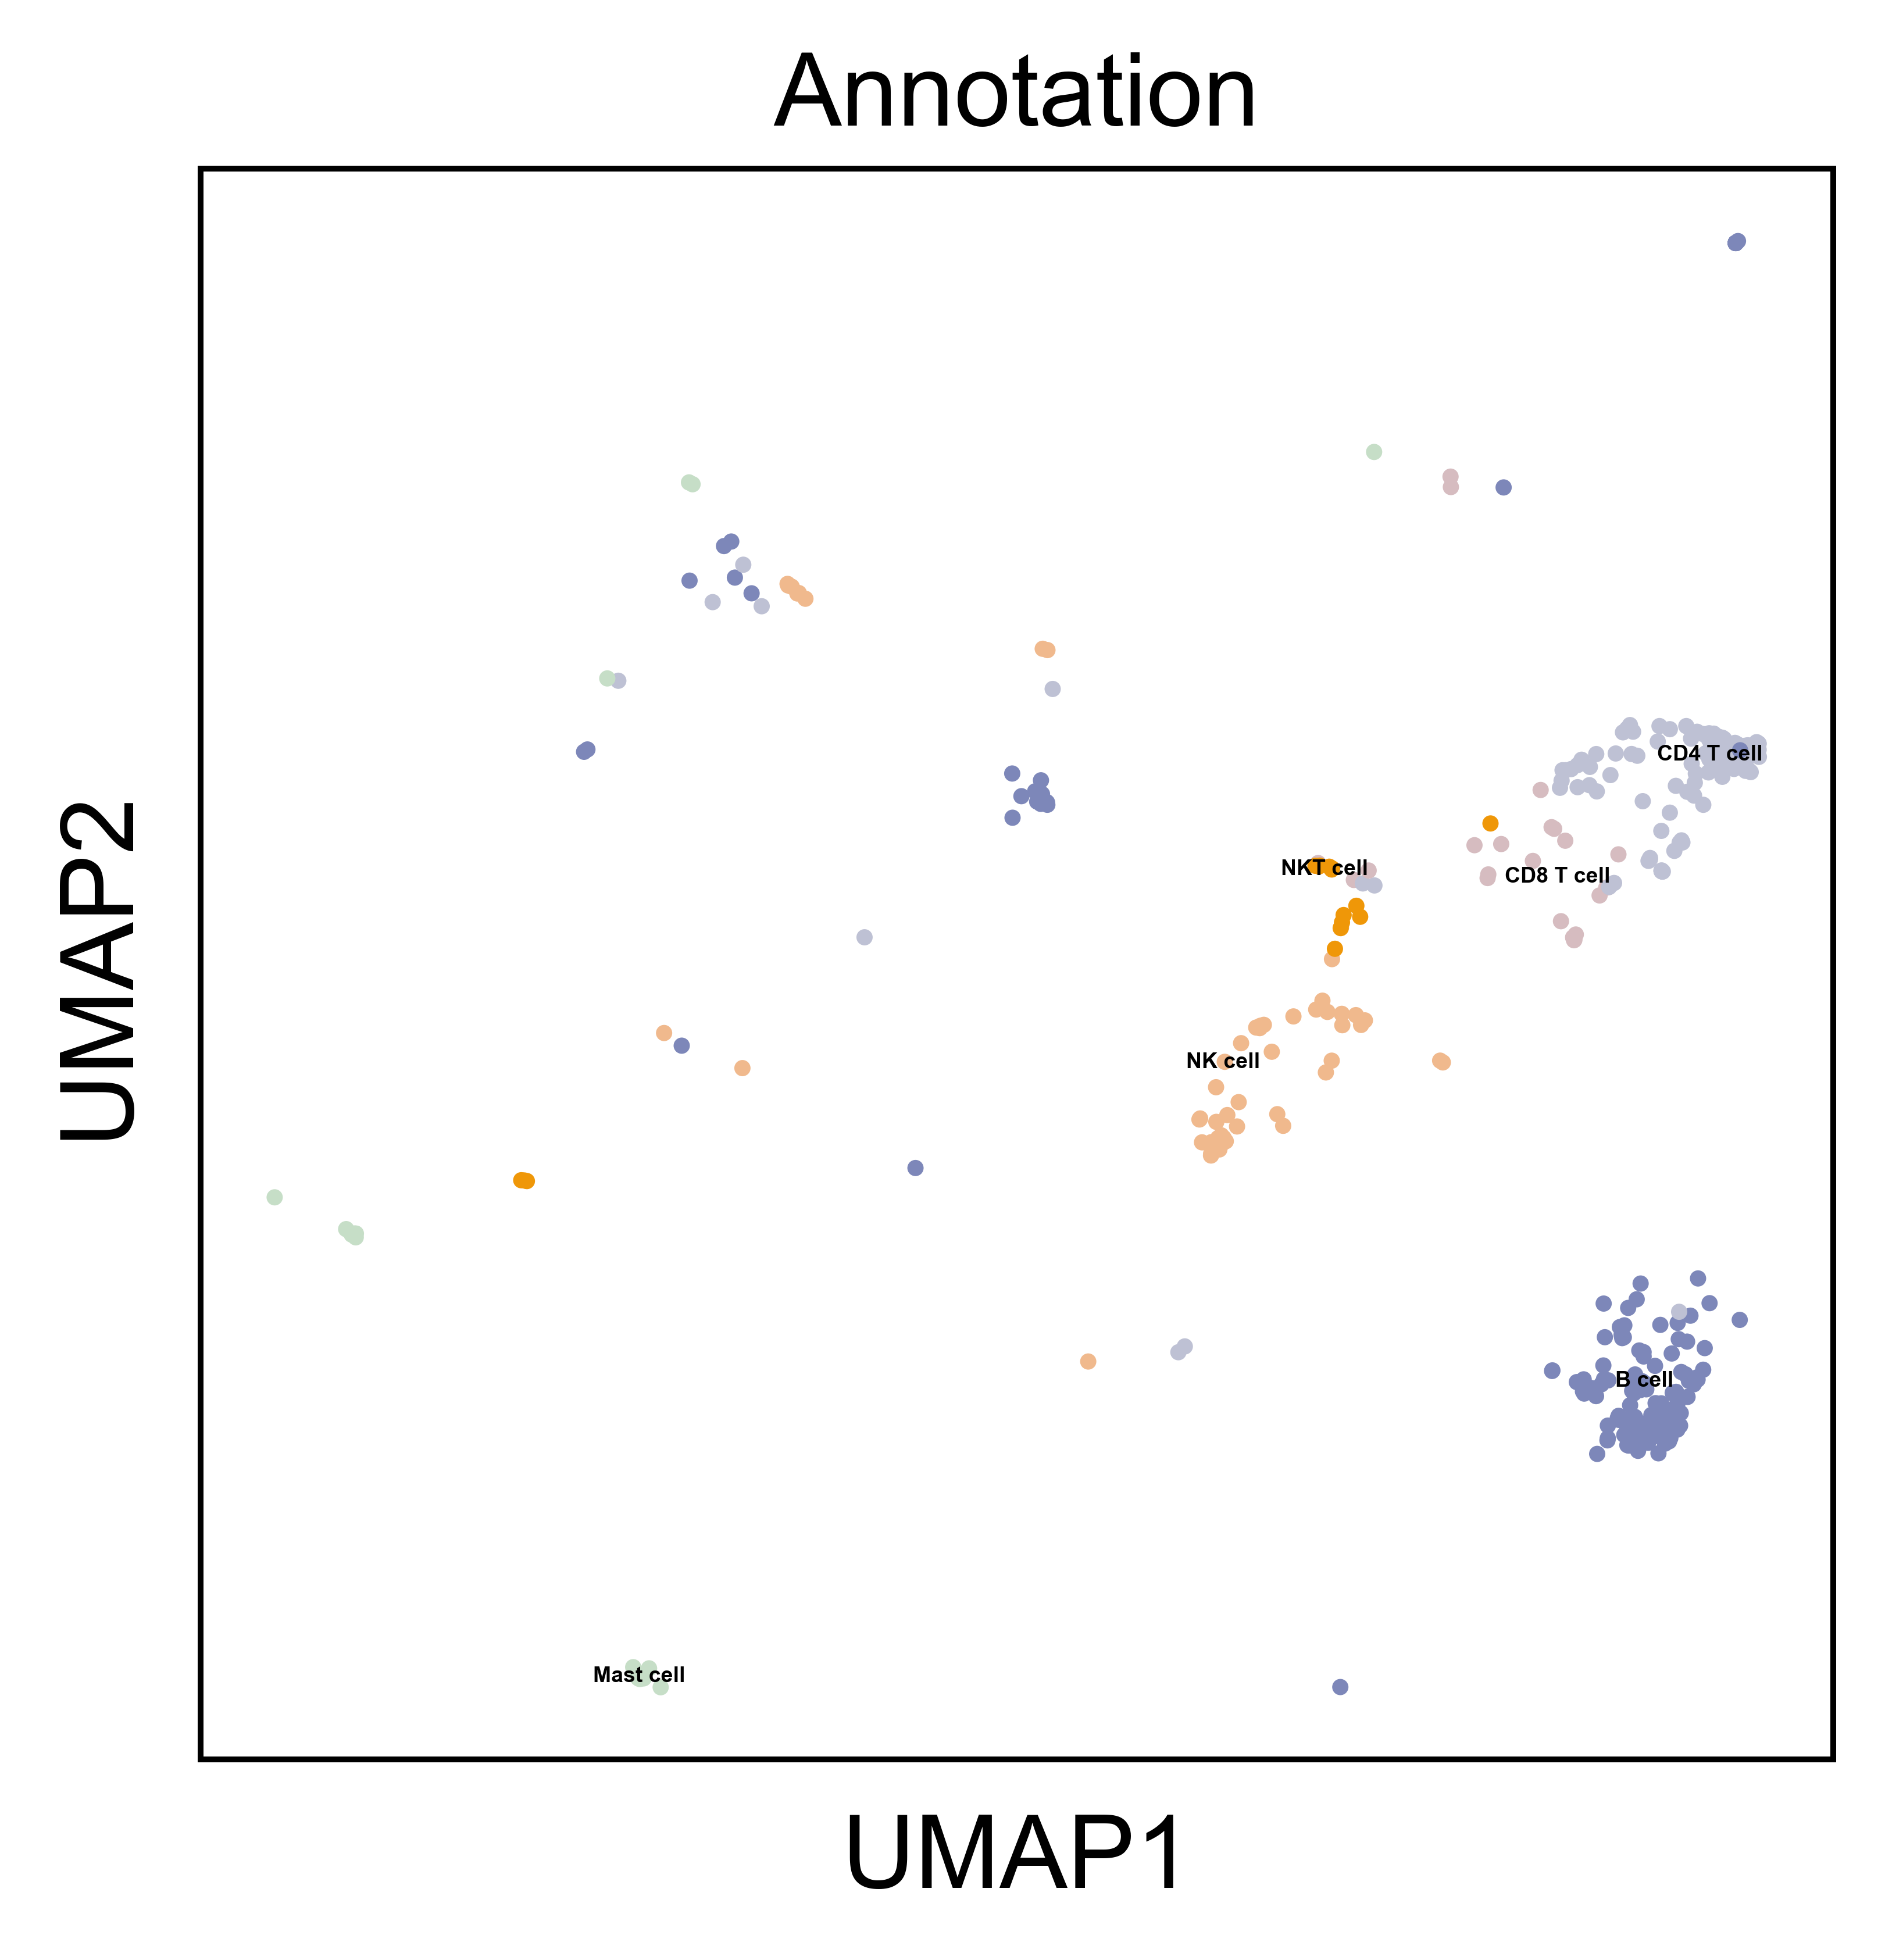

In [42]:
sc.pl.umap(subad2, color=["Annotation"],size=20,legend_loc='on data',legend_fontsize=3)